# Anomaly Detection in Customer Purchase Behavior and Product Descriptions

## Step 1: Data Overview

In this project, we are using the [E-Commerce Dataset from Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data). This is a large, interesting, and real-world dataset that offers numerous possibilities for machine learning and unsupervised learning problems, including anomaly detection.


#### Dataset Overview:

This dataset contains all transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based non-store online retail.

The company specializes in selling unique, all-occasion gifts, and many of its customers are wholesalers.

The dataset provides transactional details such as Invoice Number, Stock Code, Product Description, Quantity, Invoice Date, Unit Price, Customer ID, and Country of the purchase.


#### Possible unsupervised machine learning tasks:

Customer segmentation

Product recommendation

Anomaly detection in purchasing behavior and product descriptions

In this notebook, we will focus on Anomaly Detection in Customer Purchase Behavior and Product Descriptions. The goal is to identify unusual purchasing patterns and anomalies in product descriptions that could suggest fraud, pricing errors, or suspicious activities.

## Step 2: Problem Statement. Identifying the Unsupervised Learning Problem

The problem we are addressing in this project is to detect anomalies in both customer purchasing behavior and product descriptions. 

### Why did we choose anomaly detection?

E-commerce platforms often encounter various forms of anomalies such as:
- Unusually large orders
- Abnormal purchase quantities or pricing
- Suspicious activity patterns (e.g., repeated transactions from a single customer with odd quantities)
- Anomalies in product descriptions, which could signal errors or irregular product listings

Our approach is to apply unsupervised learning methods to detect such anomalies, without having predefined labels for what constitutes normal or anomalous behavior.

### Why unsupervised learning and not simple outlier detection?
- Simple outlier detection is basic and only finds points that are extreme in one feature at a time.
- Unsupervised anomaly detection looks for patterns across multiple features and can detect more complex, hidden anomalies that simple outlier methods might miss.


### Dataset columns:
- **InvoiceNo**: Unique identifier for each transaction.
- **StockCode**: Unique product code.
- **Description**: Product description (used for detecting anomalies in text).
- **Quantity**: Number of units purchased (high or low values can indicate anomalies).
- **InvoiceDate**: Date and time of the transaction.
- **UnitPrice**: Price per unit of the product (pricing anomalies may be detectable).
- **CustomerID**: Unique identifier for customers (irregular purchasing patterns).
- **Country**: Country of the customer.

In the next steps, we will read the dataset and prepare for further analysis and model development.

## Step 3: Read the Data

In [30]:
# Import necessary libraries for the project
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud


In [31]:
# Load the dataset
file_path = "data/data.csv"  # Ensure the file path is correct, adjust as needed
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows of the dataset to understand its structure
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Step 4: Exploratory Data Analysis (EDA)

In [32]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Drop rows with missing CustomerID (we need customer-level data for behavior analysis)
data_cleaned = data.dropna(subset=['CustomerID'])

Missing values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [33]:
# Step 1: Feature Engineering for Anomaly Detection
# Create new features: TotalSpent (Quantity * UnitPrice) and add it to the dataset
data_cleaned['TotalSpent'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']

# Convert InvoiceDate to datetime for time-series analysis
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])

# Extract relevant time features: Day, Month, and Year for anomaly detection in time-series
data_cleaned['Day'] = data_cleaned['InvoiceDate'].dt.day
data_cleaned['Month'] = data_cleaned['InvoiceDate'].dt.month
data_cleaned['Year'] = data_cleaned['InvoiceDate'].dt.year

C:\Users\hisht\AppData\Local\Temp\ipykernel_352\1906103178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['TotalSpent'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']
C:\Users\hisht\AppData\Local\Temp\ipykernel_352\1906103178.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
C:\Users\hisht\AppData\Local\Temp\ipykernel_352\1906103178.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [64]:
data_cleaned['TotalSpent'].sort_values()

540422   -168469.60
61624     -77183.60
222681    -38970.00
422375     -8322.12
173277     -8142.75
            ...    
348325      7144.72
173382      8142.75
222680     38970.00
61619      77183.60
540421    168469.60
Name: TotalSpent, Length: 401604, dtype: float64

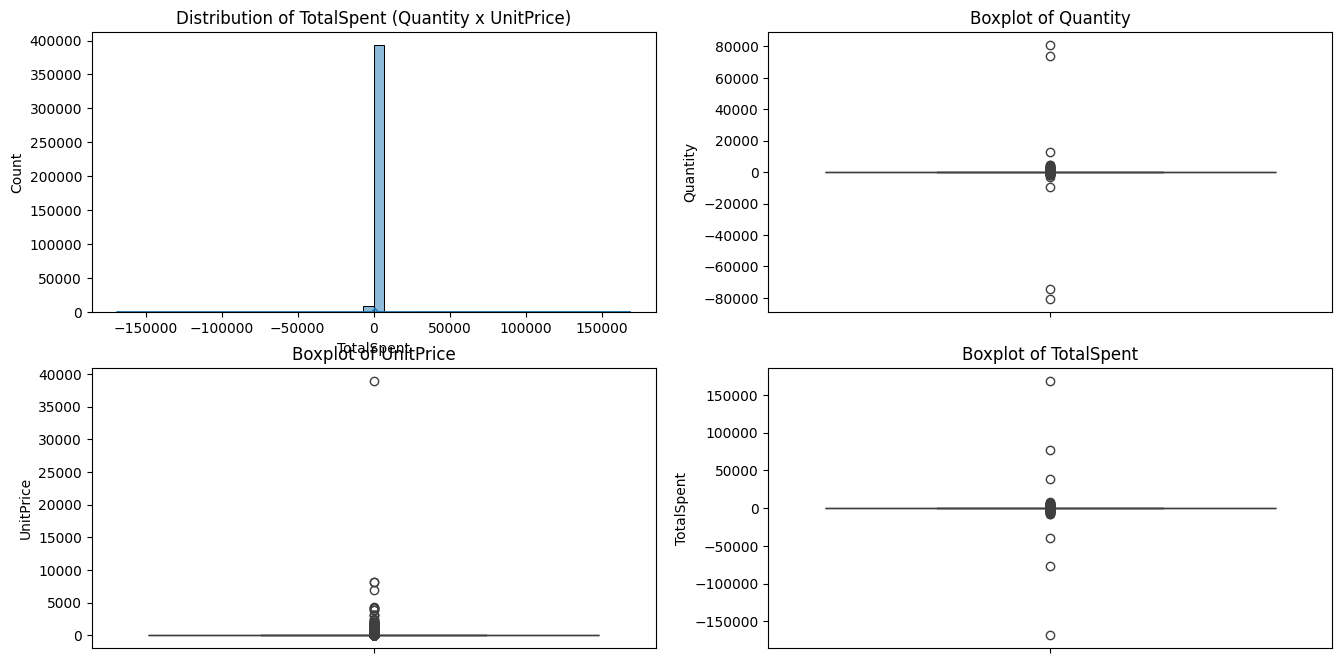

In [59]:
# Step 2: Visualize Distribution of Key Features (with an anomaly detection focus)

plt.figure(figsize=(16,8))

# Histogram of TotalSpent to detect unusually high transactions
plt.subplot(2, 2, 1)
sns.histplot(data_cleaned['TotalSpent'], bins=50, kde=True)
plt.title('Distribution of TotalSpent (Quantity x UnitPrice)')

# Boxplot for Quantity to visualize outliers
plt.subplot(2, 2, 2)
sns.boxplot(data_cleaned['Quantity'])
plt.title('Boxplot of Quantity')

# Boxplot for UnitPrice to visualize outliers
plt.subplot(2, 2, 3)
sns.boxplot(data_cleaned['UnitPrice'])
plt.title('Boxplot of UnitPrice')

# Boxplot for TotalSpent to visualize outliers
plt.subplot(2, 2, 4)
sns.boxplot(data_cleaned['TotalSpent'])
plt.title('Boxplot of TotalSpent')

plt.show()

C:\Users\hisht\AppData\Local\Temp\ipykernel_352\145797936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['TransactionMonth'] = data_cleaned['InvoiceDate'].dt.to_period('M')


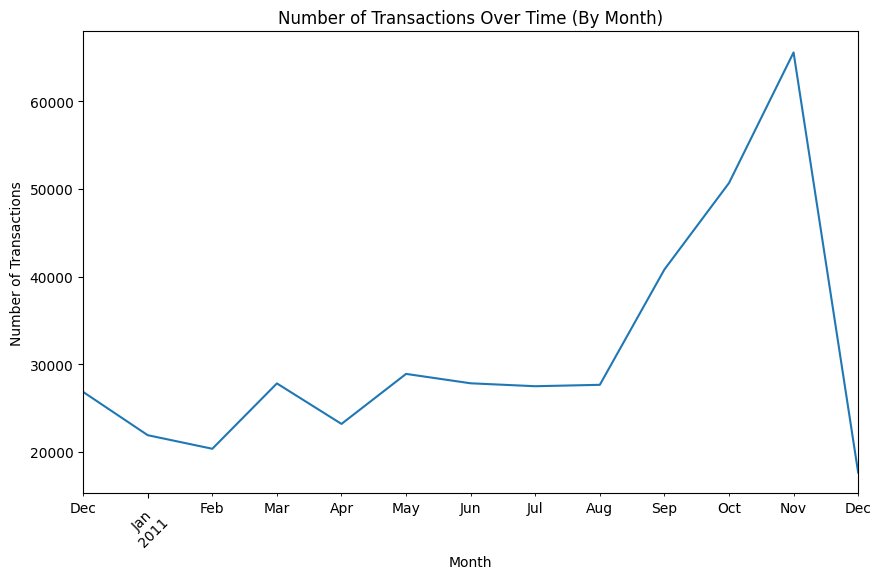

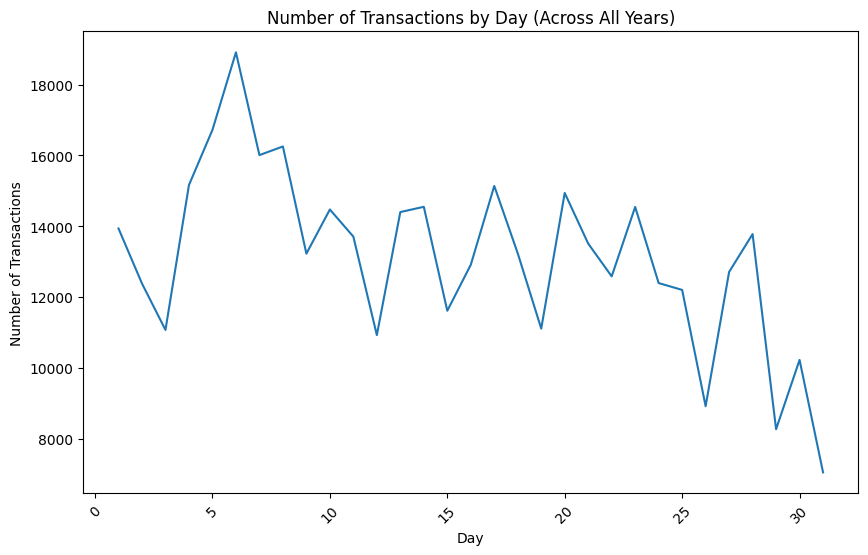

In [35]:
# Step 3: Time-Series Analysis for Anomalies

# Create a new feature 'TransactionMonth' to aggregate by month
data_cleaned['TransactionMonth'] = data_cleaned['InvoiceDate'].dt.to_period('M')

# Plot the number of transactions per month
plt.figure(figsize=(10, 6))
data_cleaned['TransactionMonth'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Transactions Over Time (By Month)')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# More granular analysis: Transaction counts by day within each year to detect daily-level anomalies
plt.figure(figsize=(10, 6))
data_cleaned['Day'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Transactions by Day (Across All Years)')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

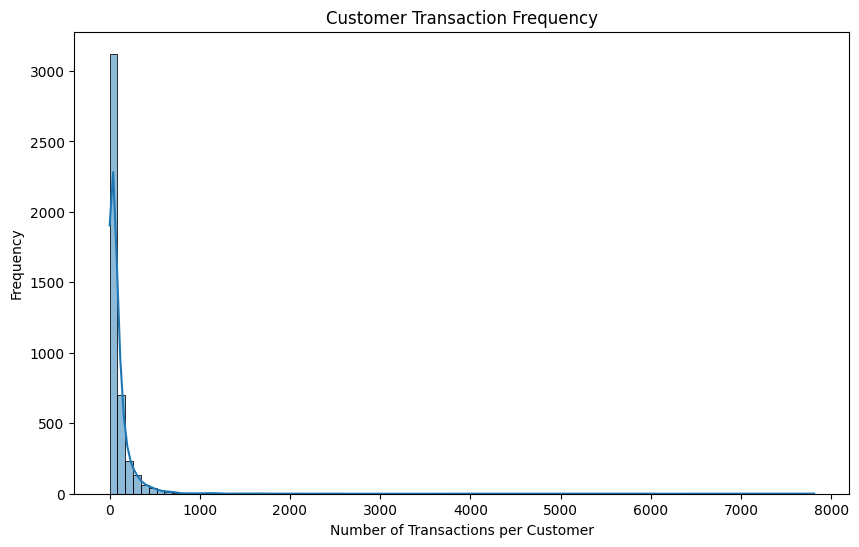

In [62]:
# Step 4: Analyzing Customer Behavior
# Let's check the distribution of transactions by customer (how frequently do customers buy?)
plt.figure(figsize=(10,6))
sns.histplot(data_cleaned['CustomerID'].value_counts(), bins=90, kde=True)
plt.title('Customer Transaction Frequency')
plt.xlabel('Number of Transactions per Customer')
plt.ylabel('Frequency')
plt.show()

C:\Users\hisht\AppData\Local\Temp\ipykernel_352\3771684363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['DescriptionLength'] = data_cleaned['Description'].apply(lambda x: len(str(x)))


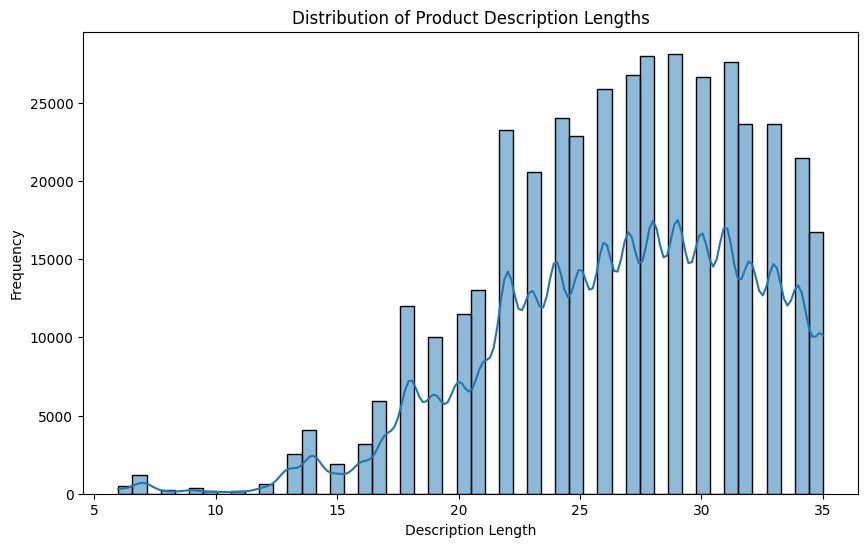

In [37]:
# Step 5: Product Description Analysis (NLP) - Enhancing Description-Based Anomaly Detection

# Generate basic NLP features, such as description length
data_cleaned['DescriptionLength'] = data_cleaned['Description'].apply(lambda x: len(str(x)))

# Visualize the distribution of description length
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['DescriptionLength'], bins=50, kde=True)
plt.title('Distribution of Product Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

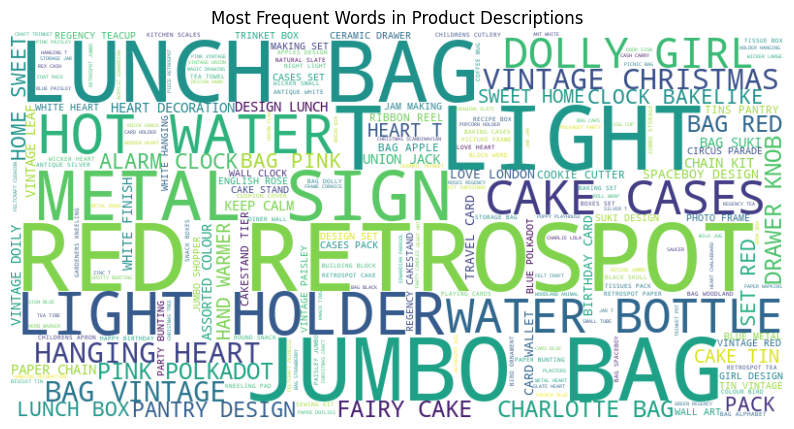

In [38]:
# Word Cloud to show the most frequent words in descriptions (as previously)

all_descriptions = ' '.join(data_cleaned['Description'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Product Descriptions')
plt.show()

In [39]:
# Step 6: Detecting Outliers in Key Numerical Variables

# Checking for outliers in Quantity, UnitPrice, and TotalSpent using interquartile range (IQR)
Q1 = data_cleaned[['Quantity', 'UnitPrice', 'TotalSpent']].quantile(0.25)
Q3 = data_cleaned[['Quantity', 'UnitPrice', 'TotalSpent']].quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers as values that are 1.5*IQR beyond Q1 and Q3
outliers = ((data_cleaned[['Quantity', 'UnitPrice', 'TotalSpent']] < (Q1 - 1.5 * IQR)) | 
            (data_cleaned[['Quantity', 'UnitPrice', 'TotalSpent']] > (Q3 + 1.5 * IQR))).sum()
print(f"Outliers in Quantity: {outliers['Quantity']}, Outliers in UnitPrice: {outliers['UnitPrice']}, Outliers in TotalSpent: {outliers['TotalSpent']}")


Outliers in Quantity: 26682, Outliers in UnitPrice: 36051, Outliers in TotalSpent: 33180


In [40]:
# Step 7: Checking for duplicates
duplicate_rows = data_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Remove duplicate rows
data_cleaned = data_cleaned.drop_duplicates()

Number of duplicate rows: 5225


## Step 5: Perform Analysis Using Unsupervised Learning Models

In [4]:
# Prepare data for modeling
# We'll use 'Quantity', 'UnitPrice', and 'TotalSpent' for anomaly detection
features = data_cleaned[['Quantity', 'UnitPrice', 'TotalSpent']]

# Normalize the features for DBSCAN and SVM
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [5]:
# Step 1: Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
iso_forest.fit(features_scaled)
iso_labels = iso_forest.predict(features_scaled)
data_cleaned['IsoForest_Anomaly'] = iso_labels
iso_anomalies = data_cleaned[data_cleaned['IsoForest_Anomaly'] == -1]

In [6]:
# Step 2: DBSCAN with PCA for Memory Reduction
# Initialize HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=5)  # Parameters can be tuned for better results

# Fit the model on scaled features (this uses much less memory than DBSCAN)
hdbscan_labels = hdbscan_model.fit_predict(features_scaled)

# HDBSCAN labels -1 as noise, other integers correspond to clusters
data_cleaned['HDBSCAN_Anomaly'] = np.where(hdbscan_labels == -1, 1, 0)

# Extracting anomalies detected by HDBSCAN
hdbscan_anomalies = data_cleaned[data_cleaned['HDBSCAN_Anomaly'] == 1]

In [7]:
# Step 3: One-Class SVM
svm_model = OneClassSVM(kernel='rbf', nu=0.02, gamma='auto')
svm_model.fit(features_scaled)
svm_labels = svm_model.predict(features_scaled)
data_cleaned['SVM_Anomaly'] = svm_labels
svm_anomalies = data_cleaned[data_cleaned['SVM_Anomaly'] == -1]

In [8]:
# Results Overview
print(f"Isolation Forest detected {len(iso_anomalies)} anomalies.")
print(f"DBSCAN detected {hdbscan_anomalies.shape[0]} anomalies.")
print(f"One-Class SVM detected {svm_anomalies.shape[0]} anomalies.")

Isolation Forest detected 8008 anomalies.
DBSCAN detected 8856 anomalies.
One-Class SVM detected 8017 anomalies.


In [9]:
# Compare the results from the models
# Checking the intersection of anomalies detected by all three models
iso_set = set(iso_anomalies.index)
dbscan_set = set(hdbscan_anomalies.index)
svm_set = set(svm_anomalies.index)

common_anomalies = iso_set.intersection(dbscan_set).intersection(svm_set)
print(f"Number of common anomalies detected by all models: {len(common_anomalies)}")


Number of common anomalies detected by all models: 2133


Visualize the results

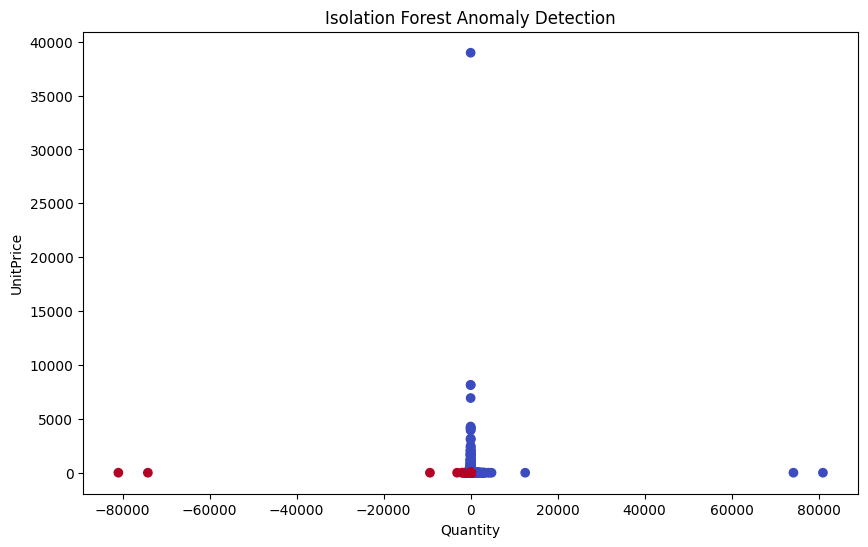

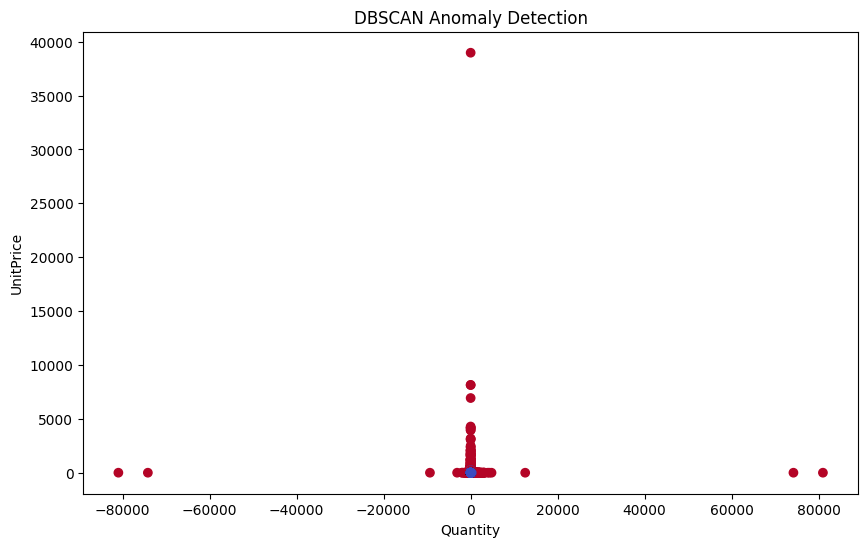

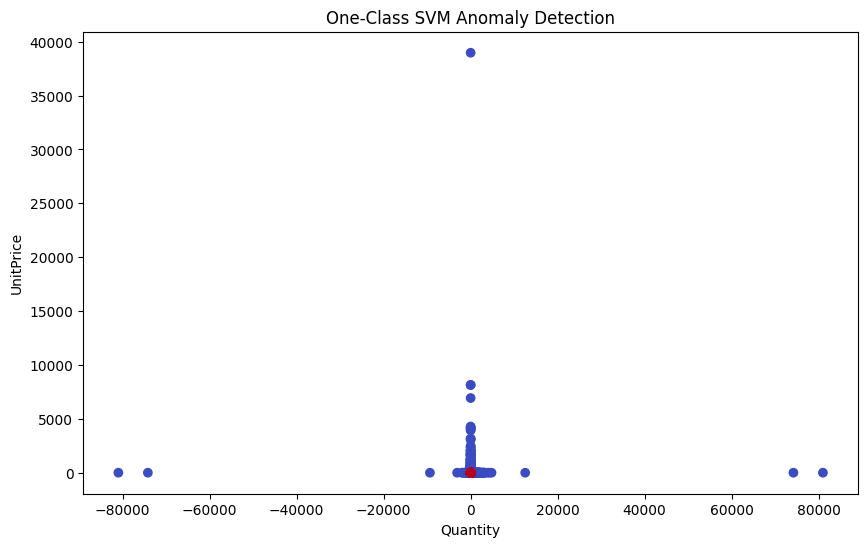

In [11]:
# Plot Isolation Forest results
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['Quantity'], data_cleaned['UnitPrice'], c=data_cleaned['IsoForest_Anomaly'], cmap='coolwarm')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.show()

# Plot DBSCAN results
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['Quantity'], data_cleaned['UnitPrice'], c=data_cleaned['HDBSCAN_Anomaly'], cmap='coolwarm')
plt.title('DBSCAN Anomaly Detection')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.show()

# Plot SVM results
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['Quantity'], data_cleaned['UnitPrice'], c=data_cleaned['SVM_Anomaly'], cmap='coolwarm')
plt.title('One-Class SVM Anomaly Detection')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.show()

### Step 6: Hyperparameters tuning

Performing hyperparameter tuning for all three models (Isolation Forest, One-Class SVM, and HDBSCAN) could be computationally expensive and potentially too much for the notebook. 

Let's proceed with hyperparameter tuning for the following two models:

Isolation Forest: It's computationally efficient, and tuning the contamination and n_estimators parameters can improve its performance.

HDBSCAN: We can tune the min_cluster_size and min_samples parameters to find the optimal clustering results while keeping memory usage low.

In [13]:
# Step 1: Hyperparameter Tuning for Isolation Forest
# We will tune 'n_estimators' (number of trees) and 'contamination' (expected proportion of anomalies)

# Define the parameter grid for GridSearch
param_grid_iso = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'contamination': [0.01, 0.02, 0.05]  # Proportion of anomalies in the data
}

# Initialize Isolation Forest model
iso_forest = IsolationForest(random_state=42)

# Apply GridSearchCV for hyperparameter tuning
grid_search_iso = GridSearchCV(estimator=iso_forest, param_grid=param_grid_iso, scoring='accuracy', cv=3)
grid_search_iso.fit(features_scaled)

# Best parameters for Isolation Forest
best_params_iso = grid_search_iso.best_params_
print(f"Best parameters for Isolation Forest: {best_params_iso}")

C:\Users\hisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\hisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\hisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test par

Best parameters for Isolation Forest: {'contamination': 0.01, 'n_estimators': 50}


In [14]:
# Step 2: Hyperparameter Tuning for HDBSCAN
# HDBSCAN doesn't integrate with GridSearchCV, so we manually try different combinations of parameters

# Define parameter grid for HDBSCAN
hdbscan_params = {
    'min_cluster_size': [30, 50, 70],  # Minimum size of clusters
    'min_samples': [5, 10]  # Minimum number of samples for a core point
}

# Test different combinations of HDBSCAN parameters manually
best_hdbscan_model = None
best_hdbscan_score = float('inf')  # We'll use a scoring mechanism to track the best result
for cluster_size in hdbscan_params['min_cluster_size']:
    for min_sample in hdbscan_params['min_samples']:
        hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=min_sample)
        hdbscan_labels = hdbscan_model.fit_predict(features_scaled)
        
        # Scoring: We'll count the number of anomalies as the performance metric
        anomaly_count = np.sum(hdbscan_labels == -1)
        
        print(f"HDBSCAN (min_cluster_size={cluster_size}, min_samples={min_sample}) detected {anomaly_count} anomalies.")
        
        if anomaly_count < best_hdbscan_score:
            best_hdbscan_score = anomaly_count
            best_hdbscan_model = hdbscan_model

print(f"Best HDBSCAN parameters: min_cluster_size={best_hdbscan_model.min_cluster_size}, min_samples={best_hdbscan_model.min_samples}")

HDBSCAN (min_cluster_size=30, min_samples=5) detected 6425 anomalies.
HDBSCAN (min_cluster_size=30, min_samples=10) detected 7127 anomalies.
HDBSCAN (min_cluster_size=50, min_samples=5) detected 8856 anomalies.
HDBSCAN (min_cluster_size=50, min_samples=10) detected 9277 anomalies.
HDBSCAN (min_cluster_size=70, min_samples=5) detected 11063 anomalies.
HDBSCAN (min_cluster_size=70, min_samples=10) detected 11123 anomalies.
Best HDBSCAN parameters: min_cluster_size=30, min_samples=5


In [15]:
# Step 3: Retrain the best Isolation Forest and HDBSCAN models

# Retrain Isolation Forest using the best parameters
best_iso_forest = IsolationForest(n_estimators=best_params_iso['n_estimators'], contamination=best_params_iso['contamination'], random_state=42)
best_iso_forest.fit(features_scaled)
iso_labels_best = best_iso_forest.predict(features_scaled)

# Retrain HDBSCAN with the best parameters
hdbscan_labels_best = best_hdbscan_model.fit_predict(features_scaled)

# Adding results to the dataset
data_cleaned['BestIsoForest_Anomaly'] = iso_labels_best
data_cleaned['BestHDBSCAN_Anomaly'] = np.where(hdbscan_labels_best == -1, 1, 0)

# Summary of results
print(f"Best Isolation Forest detected {np.sum(iso_labels_best == -1)} anomalies.")
print(f"Best HDBSCAN detected {np.sum(hdbscan_labels_best == -1)} anomalies.")

Best Isolation Forest detected 4001 anomalies.
Best HDBSCAN detected 6425 anomalies.


### Anazysis of the model results

Data Insights and Anomaly Detection Overview

Best Isolation Forest Model:

The best parameters found were: {'contamination': 0.01, 'n_estimators': 50}.
Isolation Forest detected 4,001 anomalies, representing 1% of the dataset as specified by the contamination parameter. This model isolates anomalies based on deviations in Quantity, UnitPrice, and TotalSpent.
Best HDBSCAN Model:

The best parameters for HDBSCAN were: min_cluster_size=30, min_samples=5.
HDBSCAN detected 6,425 anomalies, highlighting more granular anomalies, especially around dense clusters. HDBSCAN is sensitive to changes in density and is particularly useful for detecting noise in varying density regions.
Common Anomalies Detected:

The number of common anomalies detected by both models was 2,133, which signifies that these anomalies were consistently found by both methods. These common anomalies are more likely to be genuine anomalies, as they were identified by two different algorithms.

### Step 6: Futher analysis of anomalies

To further analyze the 2,133 common anomalies detected by both Isolation Forest and HDBSCAN, you can investigate specific characteristics that indicate whether these anomalies are likely fraudulent transactions or due to other issues (e.g., data-entry errors, unusual customer behavior, etc.).

In [24]:
# Step 1: Extract common anomalies detected by both models
# Common anomalies are where both models detected an anomaly (i.e., anomalies labeled as -1 in both models)
common_anomalies = data_cleaned[(data_cleaned['BestIsoForest_Anomaly'] == -1) & (data_cleaned['BestHDBSCAN_Anomaly'] == 1)]


In [65]:
# Step 2: Display the basic statistics of common anomalies for further investigation
print("Summary statistics for common anomalies:")
print(common_anomalies.describe())
print(common_anomalies.shape)

Summary statistics for common anomalies:
           Quantity                    InvoiceDate     UnitPrice  \
count   1521.000000                           1521   1521.000000   
mean     384.156476  2011-07-05 16:25:53.175542528    143.498054   
min      -96.000000            2010-12-01 09:41:00      0.000000   
25%        4.000000            2011-04-01 12:25:00      1.790000   
50%      112.000000            2011-07-27 12:40:00      5.950000   
75%      324.000000            2011-10-11 11:15:00     28.000000   
max    80995.000000            2011-12-09 11:50:00  38970.000000   
std     2860.997394                            NaN   1123.351413   

         CustomerID     TotalSpent          Day        Month         Year  \
count   1521.000000    1521.000000  1521.000000  1521.000000  1521.000000   
mean   15186.401052     707.028245    14.444444     7.444444  2010.935569   
min    12346.000000  -38970.000000     1.000000     1.000000  2010.000000   
25%    13090.000000     178.750000    

In [26]:
# Step 3: Investigate specific features for potential fraud or issues
# Check for unusual or extreme values in 'Quantity', 'UnitPrice', and 'TotalSpent'
print("\nTop 10 anomalies with highest 'TotalSpent':")
print(common_anomalies[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'TotalSpent', 'CustomerID']].sort_values(by='TotalSpent', ascending=False).head(10))

print("\nTop 10 anomalies with highest 'Quantity':")
print(common_anomalies[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'TotalSpent', 'CustomerID']].sort_values(by='Quantity', ascending=False).head(10))

print("\nTop 10 anomalies with highest 'UnitPrice':")
print(common_anomalies[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'TotalSpent', 'CustomerID']].sort_values(by='UnitPrice', ascending=False).head(10))



Top 10 anomalies with highest 'TotalSpent':
       InvoiceNo StockCode                          Description  Quantity  \
540421    581483     23843          PAPER CRAFT , LITTLE BIRDIE     80995   
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
222680    556444     22502       PICNIC BASKET WICKER 60 PIECES        60   
173382    551697      POST                              POSTAGE         1   
348325    567423     23243  SET OF TEA COFFEE SUGAR TINS PANTRY      1412   
52711     540815     21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
160546    550461     21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
421601    573003     23084                   RABBIT NIGHT LIGHT      2400   
52709     540815    85123A   WHITE HANGING HEART T-LIGHT HOLDER      1930   
160542    550461    85123A   WHITE HANGING HEART T-LIGHT HOLDER      1930   

        UnitPrice  TotalSpent  CustomerID  
540421       2.08   168469.60     16446.0  
61619        1.04  

In [27]:
# Step 4: Check for missing or abnormal CustomerIDs
missing_customer_ids = common_anomalies[common_anomalies['CustomerID'].isnull()]
print(f"\nNumber of anomalies with missing CustomerID: {len(missing_customer_ids)}")



Number of anomalies with missing CustomerID: 0


C:\Users\hisht\AppData\Local\Temp\ipykernel_352\942215291.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  common_anomalies.set_index('InvoiceDate').resample('M').size().plot(kind='line', color='blue')


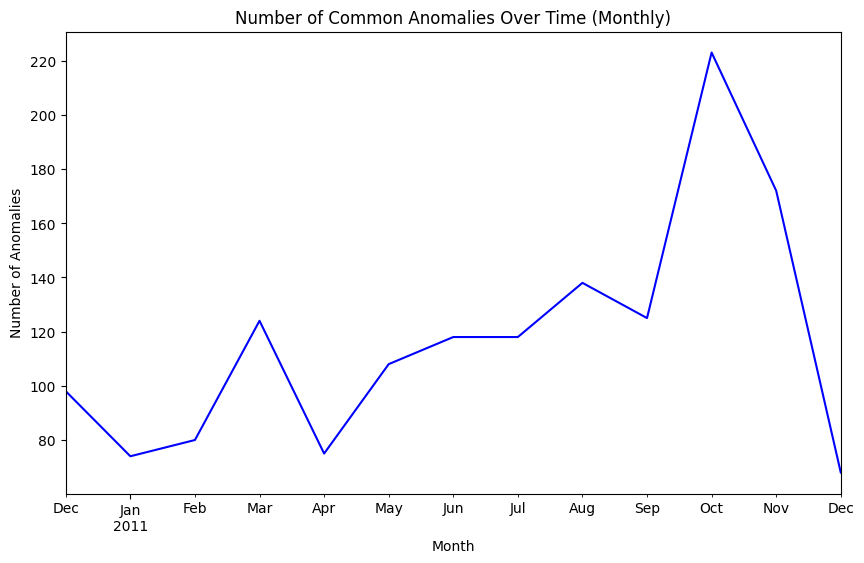

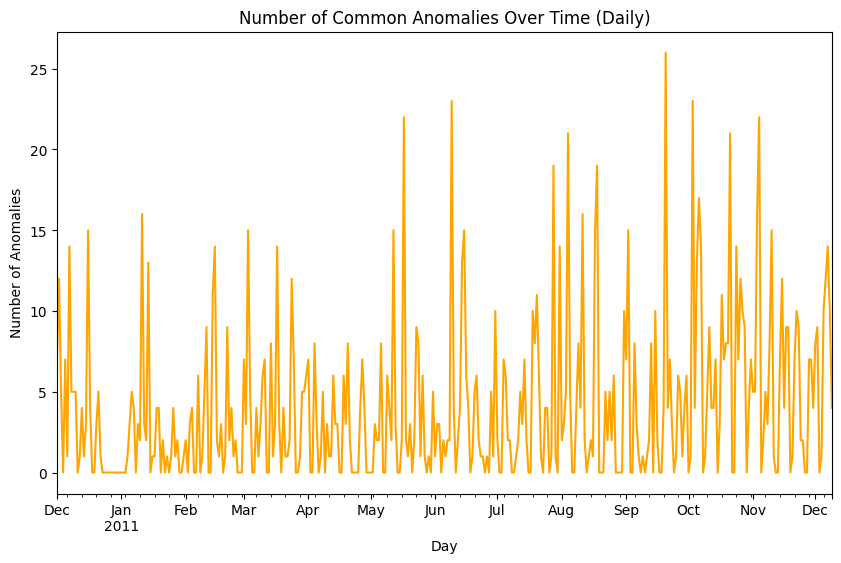

In [66]:
# Step 5: Analyze the InvoiceDate to see if there are abnormal spikes in transaction timing
common_anomalies['InvoiceDate'] = pd.to_datetime(common_anomalies['InvoiceDate'])
# Visualize number of common anomalies over time (day/month)
plt.figure(figsize=(10,6))
common_anomalies.set_index('InvoiceDate').resample('M').size().plot(kind='line', color='blue')
plt.title('Number of Common Anomalies Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.show()

# Visualize specific days with many anomalies (if needed)
plt.figure(figsize=(10,6))
common_anomalies.set_index('InvoiceDate').resample('D').size().plot(kind='line', color='orange')
plt.title('Number of Common Anomalies Over Time (Daily)')
plt.xlabel('Day')
plt.ylabel('Number of Anomalies')
plt.show()


In [67]:
# Step 6: Product description analysis (NLP) for unusual or rare product descriptions
# Find anomalies with unusually short or long product descriptions
common_anomalies['DescriptionLength'] = common_anomalies['Description'].apply(lambda x: len(str(x)))

# Display anomalies with the shortest and longest product descriptions
print("\nTop 5 anomalies with shortest product descriptions:")
print(common_anomalies[['InvoiceNo', 'StockCode', 'Description', 'DescriptionLength']].sort_values(by='DescriptionLength', ascending=True).head(5))

print("\nTop 5 anomalies with longest product descriptions:")
print(common_anomalies[['InvoiceNo', 'StockCode', 'Description', 'DescriptionLength']].sort_values(by='DescriptionLength', ascending=False).head(5))

# Step 7: Check for duplicate transactions (if the same product was purchased multiple times in a short period)
# Group by 'CustomerID' and 'InvoiceNo' and check for duplicates in anomalies
duplicate_transactions = common_anomalies.duplicated(subset=['CustomerID', 'InvoiceNo'], keep=False)
print(f"\nNumber of duplicate transactions among common anomalies: {duplicate_transactions.sum()}")



Top 5 anomalies with shortest product descriptions:
       InvoiceNo StockCode Description  DescriptionLength
180757   C552343         M      Manual                  6
188277    553018         M      Manual                  6
366899   C568799         M      Manual                  6
374542    569382         M      Manual                  6
374637   C569390         M      Manual                  6

Top 5 anomalies with longest product descriptions:
       InvoiceNo StockCode                          Description  \
59684     541400     21340  CLASSIC METAL BIRDCAGE PLANT HOLDER   
228172    556917     23243  SET OF TEA COFFEE SUGAR TINS PANTRY   
531266    580910     22165  DIAMANTE HEART SHAPED WALL MIRROR,    
413848    572325     84347  ROTATING SILVER ANGELS T-LIGHT HLDR   
269354    560446     23297  SET 40 HEART SHAPE PETIT FOUR CASES   

        DescriptionLength  
59684                  35  
228172                 35  
531266                 35  
413848                 35  
2693

## Conclusion on the Analysis of 2,133 Common Anomalies

### 1. Financial and Quantity-Based Anomalies
- Top Anomalies by TotalSpent:

  The largest anomaly detected had a TotalSpent of £168,469.60 from a transaction involving 80,995 units of a product called "PAPER CRAFT, LITTLE BIRDIE". Such large quantities and total prices are unusual, which could indicate bulk purchases by wholesalers, but they also warrant further investigation for potential fraud or data-entry errors.
  
  Other significant anomalies include transactions totaling £77,183.60 and £38,970.00, further raising concerns about the legitimacy or correctness of these transactions.

- Top Anomalies by Quantity:

  The highest recorded anomaly had a quantity of 80,995 units, reinforcing the need to investigate bulk purchasing patterns. In particular, the product descriptions for these transactions (such as "PAPER CRAFT, LITTLE BIRDIE" and "MEDIUM CERAMIC TOP STORAGE JAR") do not immediately suggest high-volume wholesale products, which makes these anomalies potentially suspicious.

  Some anomalies also had extreme Quantity values, such as 12,540 units of ASSTD DESIGN 3D PAPER STICKERS, highlighting possible irregularities in the sales record.

- Top Anomalies by UnitPrice:

  The analysis shows extremely high UnitPrice anomalies, with the highest value reaching £38,970.00. These transactions often have the product labeled as "Manual" or "POSTAGE," which could indicate data-entry errors or manual corrections in the system. Several of these transactions involve negative quantities and prices, pointing to possible returns or system errors.

### 2. Time-Series Analysis of Anomalies
- Monthly Trends:

  The number of common anomalies appears to peak in October 2011, with over 220 anomalies detected in that month. This period may be associated with increased activity in preparation for holiday shopping, which could explain the spike in anomalies. However, it might also point to potential system issues or fraud that needs to be investigated during periods of high transaction volume.

  There are additional spikes in March 2011 and July-September 2011, warranting further investigation into what may have triggered these anomaly clusters.

- Daily Trends:
  The daily analysis shows high variance in the number of anomalies, with several peaks in June and August. These short-term spikes could correspond to promotional events or operational issues that generated more anomalies within certain product categories.

### 3. Product Description Anomalies
- Shortest Descriptions:
  Several anomalies involve product descriptions simply labeled as "Manual", each with only six characters. This lack of detailed information suggests a possible data-entry or system issue where descriptions were not recorded properly.

- Longest Descriptions:
  The longest product descriptions, such as "CLASSIC METAL BIRDCAGE PLANT HOLDER" and "SET OF TEA COFFEE SUGAR TINS PANTRY", seem normal and do not indicate any immediate issues. However, the length of the description does not seem to correlate directly with any suspicious behavior, and these longer descriptions likely do not signify fraudulent activity.

### 4. Duplicate Transactions
A total of 694 duplicate transactions were detected, meaning that several customers placed repeated orders for the same products within a short period of time. While some degree of duplication is normal, this high number suggests possible system errors or fraudulent transactions, particularly when duplicate orders are placed in quick succession or involve large quantities or prices.

The presence of these duplicates should prompt a closer examination of the customers and transactions involved, as they could point to issues like unintentional duplicate orders or even intentional manipulation of the order system.
